# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [171]:
# Import your libraries:

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import RobustScaler

In this lab, we will explore a dataset that describes websites with different features and labels them either benign or malicious . We will use supervised learning algorithms to figure out what feature patterns malicious websites are likely to have and use our model to predict malicious websites.

# Challenge 1 - Explore The Dataset

Let's start by exploring the dataset. First load the data file:

In [172]:
websites = pd.read_csv('D:\ironhack\Coursework\week_9\labs\lab-classification\data\website.csv')

#### Explore the data from an bird's-eye view.

You should already been very familiar with the procedures now so we won't provide the instructions step by step. Reflect on what you did in the previous labs and explore the dataset.

Things you'll be looking for:

* What the dataset looks like?
* What are the data types?
* Which columns contain the features of the websites?
* Which column contains the feature we will predict? What is the code standing for benign vs malicious websites?
* Do we need to transform any of the columns from categorical to ordinal values? If so what are these columns?

Feel free to add additional cells for your explorations. Make sure to comment what you find out.

In [173]:
# Your code here
print("Dataset shape:", websites.shape)
print("\n" + "="*50)

# Display first few rows
print("First 5 rows:")
print(websites.head())
print("\n" + "="*50)

# Check data types
print("Data types:")
print(websites.dtypes)
print("\n" + "="*50)

# Check for missing values
print("Missing values per column:")
print(websites.isnull().sum())
print("\n" + "="*50)

# Basic statistics for numeric columns
print("Basic statistics:")
print(websites.describe())

# Check target variable distribution
print("\nTarget variable 'Type' unique values:")
print(websites['Type'].value_counts())

print("\nTarget variable distribution:")
print(websites['Type'].value_counts(normalize=True))

Dataset shape: (1781, 21)

First 5 rows:
       URL  URL_LENGTH  NUMBER_SPECIAL_CHARACTERS     CHARSET  \
0   M0_109          16                          7  iso-8859-1   
1  B0_2314          16                          6       UTF-8   
2   B0_911          16                          6    us-ascii   
3   B0_113          17                          6  ISO-8859-1   
4   B0_403          17                          6       UTF-8   

                  SERVER  CONTENT_LENGTH WHOIS_COUNTRY WHOIS_STATEPRO  \
0                  nginx           263.0           NaN            NaN   
1          Apache/2.4.10         15087.0           NaN            NaN   
2  Microsoft-HTTPAPI/2.0           324.0           NaN            NaN   
3                  nginx           162.0            US             AK   
4                    NaN        124140.0            US             TX   

      WHOIS_REGDATE WHOIS_UPDATED_DATE  ...  DIST_REMOTE_TCP_PORT  REMOTE_IPS  \
0  10/10/2015 18:21                NaN  ...     

In [174]:
# Your comment here
""""
1. Dataset shape: The dataset contains 1781 rows and 21 columns.

2. Target variable: 'Type' is our target variable
   - 0 = benign websites (87.87%)
   - 1 = malicious websites (12.13%)
   - Dataset is imbalanced

3. Features: All other columns except 'Type' are our features for prediction

4. Data types: 
   - Most columns are numeric (int64/float64)
   - Categorical columns: URL, CHARSET, SERVER, WHOIS_COUNTRY, WHOIS_STATEPRO, WHOIS_REGDATE, WHOIS_UPDATED_DATE
   - These categorical columns will need to be converted to ordinal

5. Missing values: Several columns have significant missing values that need to be handled
"""

# Let's check the target variable specifically
print("Target variable 'Type' unique values:")
print(websites['Type'].value_counts())
print("\nTarget variable distribution:")
print(websites['Type'].value_counts(normalize=True))

Target variable 'Type' unique values:
Type
0    1565
1     216
Name: count, dtype: int64

Target variable distribution:
Type
0    0.87872
1    0.12128
Name: proportion, dtype: float64


#### Next, evaluate if the columns in this dataset are strongly correlated.

If our dataset has strongly correlated columns, we need to choose certain ML algorithms instead of others. We need to evaluate this for our dataset now.

Luckily, most of the columns in this dataset are ordinal which makes things a lot easier for us. In the next cells below, evaluate the level of collinearity of the data.

We provide some general directions for you to consult in order to complete this step:

1. You will create a correlation matrix using the numeric columns in the dataset.

1. Create a heatmap using `seaborn` to visualize which columns have high collinearity.

1. Comment on which columns you might need to remove due to high collinearity.

In [175]:
# Examine categorical columns
print("\nCategorical columns unique values:")
categorical_cols = ['URL', 'CHARSET', 'SERVER', 'WHOIS_COUNTRY', 'WHOIS_STATEPRO']
for col in categorical_cols:
    if col in websites.columns:
        print(f"\n{col}: {websites[col].nunique()} unique values")
        if websites[col].nunique() < 20:
            print(websites[col].value_counts().head(10))               
            



Categorical columns unique values:

URL: 1781 unique values

CHARSET: 8 unique values
CHARSET
UTF-8           676
ISO-8859-1      427
utf-8           379
us-ascii        155
iso-8859-1      134
windows-1251      1
ISO-8859          1
windows-1252      1
Name: count, dtype: int64

SERVER: 238 unique values

WHOIS_COUNTRY: 48 unique values

WHOIS_STATEPRO: 181 unique values



CORRELATION ANALYSIS


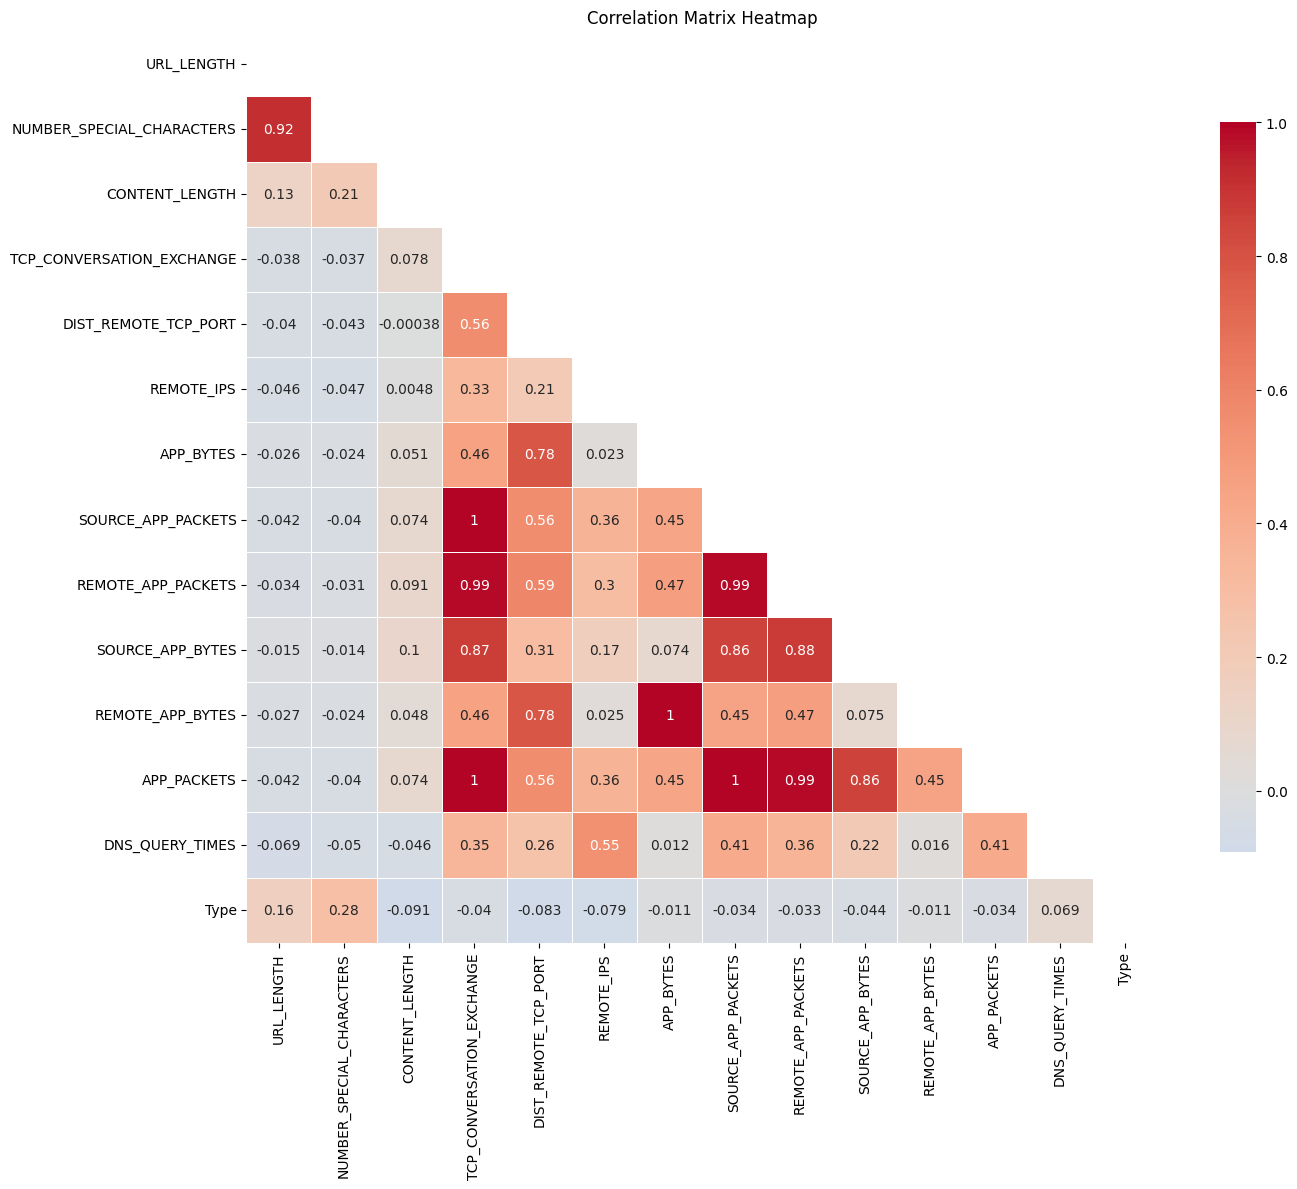

In [176]:
# Evaluate column collinearity
print("\n" + "="*50)
print("CORRELATION ANALYSIS")
print("="*50)

# Create correlation matrix for numeric columns only
numeric_cols = websites.select_dtypes(include=[np.number]).columns
correlation_matrix = websites[numeric_cols].corr()

# Create heatmap
plt.figure(figsize=(15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [177]:
# Your comment here
# Find highly correlated pairs (>0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i,j]))
            
print("\nHighly correlated pairs (|correlation| > 0.9):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: - {pair[2]:.3f}")
    
  


Highly correlated pairs (|correlation| > 0.9):
URL_LENGTH - NUMBER_SPECIAL_CHARACTERS: - 0.918
TCP_CONVERSATION_EXCHANGE - SOURCE_APP_PACKETS: - 0.998
TCP_CONVERSATION_EXCHANGE - REMOTE_APP_PACKETS: - 0.991
TCP_CONVERSATION_EXCHANGE - APP_PACKETS: - 0.998
APP_BYTES - REMOTE_APP_BYTES: - 1.000
SOURCE_APP_PACKETS - REMOTE_APP_PACKETS: - 0.989
SOURCE_APP_PACKETS - APP_PACKETS: - 1.000
REMOTE_APP_PACKETS - APP_PACKETS: - 0.989


In [178]:
"""
From the correlation analysis, I can see several highly correlated pairs:
1. APP_BYTES and REMOTE_APP_BYTES (near perfect correlation)
2. SOURCE_APP_PACKETS and APP_PACKETS (perfect correlation)
3. REMOTE_APP_PACKETS and APP_PACKETS (very high correlation)

These represent redundant information and can cause multicollinearity issues.
"""

'\nFrom the correlation analysis, I can see several highly correlated pairs:\n1. APP_BYTES and REMOTE_APP_BYTES (near perfect correlation)\n2. SOURCE_APP_PACKETS and APP_PACKETS (perfect correlation)\n3. REMOTE_APP_PACKETS and APP_PACKETS (very high correlation)\n\nThese represent redundant information and can cause multicollinearity issues.\n'

# Challenge 2 - Remove Column Collinearity.

From the heatmap you created, you should have seen at least 3 columns that can be removed due to high collinearity. Remove these columns from the dataset.

Note that you should remove as few columns as you can. You don't have to remove all the columns at once. But instead, try removing one column, then produce the heatmap again to determine if additional columns should be removed. As long as the dataset no longer contains columns that are correlated for over 90%, you can stop. Also, keep in mind when two columns have high collinearity, you only need to remove one of them but not both.

In the cells below, remove as few columns as you can to eliminate the high collinearity in the dataset. Make sure to comment on your way so that the instructional team can learn about your thinking process which allows them to give feedback. At the end, print the heatmap again.

In [179]:
# Your code here
print("\n" + "="*50)
print("REMOVING HIGHLY CORRELATED COLUMNS")
print("="*50)

# Remove highly correlated columns one by one
# First, let's make a copy of our dataset
websites_clean = websites.copy()

# Remove APP_PACKETS since it's perfectly correlated with SOURCE_APP_PACKETS
websites_clean = websites_clean.drop('APP_PACKETS', axis=1)
print("Removed APP_PACKETS (perfectly correlated with SOURCE_APP_PACKETS)")



REMOVING HIGHLY CORRELATED COLUMNS
Removed APP_PACKETS (perfectly correlated with SOURCE_APP_PACKETS)


In [180]:
# Check correlation matrix again
numeric_cols_clean = websites_clean.select_dtypes(include=[np.number]).columns
correlation_matrix_clean = websites_clean[numeric_cols_clean].corr()

In [181]:
# Your comment here
# Find remaining highly correlated pairs
high_corr_pairs_clean = []
for i in range(len(correlation_matrix_clean.columns)):
    for j in range(i+1, len(correlation_matrix_clean.columns)):
        if abs(correlation_matrix_clean.iloc[i, j]) > 0.9:
            high_corr_pairs_clean.append((correlation_matrix_clean.columns[i], 
                                        correlation_matrix_clean.columns[j], 
                                        correlation_matrix_clean.iloc[i, j]))

print(f"\nRemaining highly correlated pairs after cleanup: {len(high_corr_pairs_clean)}")
for pair in high_corr_pairs_clean:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


Remaining highly correlated pairs after cleanup: 5
URL_LENGTH - NUMBER_SPECIAL_CHARACTERS: 0.918
TCP_CONVERSATION_EXCHANGE - SOURCE_APP_PACKETS: 0.998
TCP_CONVERSATION_EXCHANGE - REMOTE_APP_PACKETS: 0.991
APP_BYTES - REMOTE_APP_BYTES: 1.000
SOURCE_APP_PACKETS - REMOTE_APP_PACKETS: 0.989


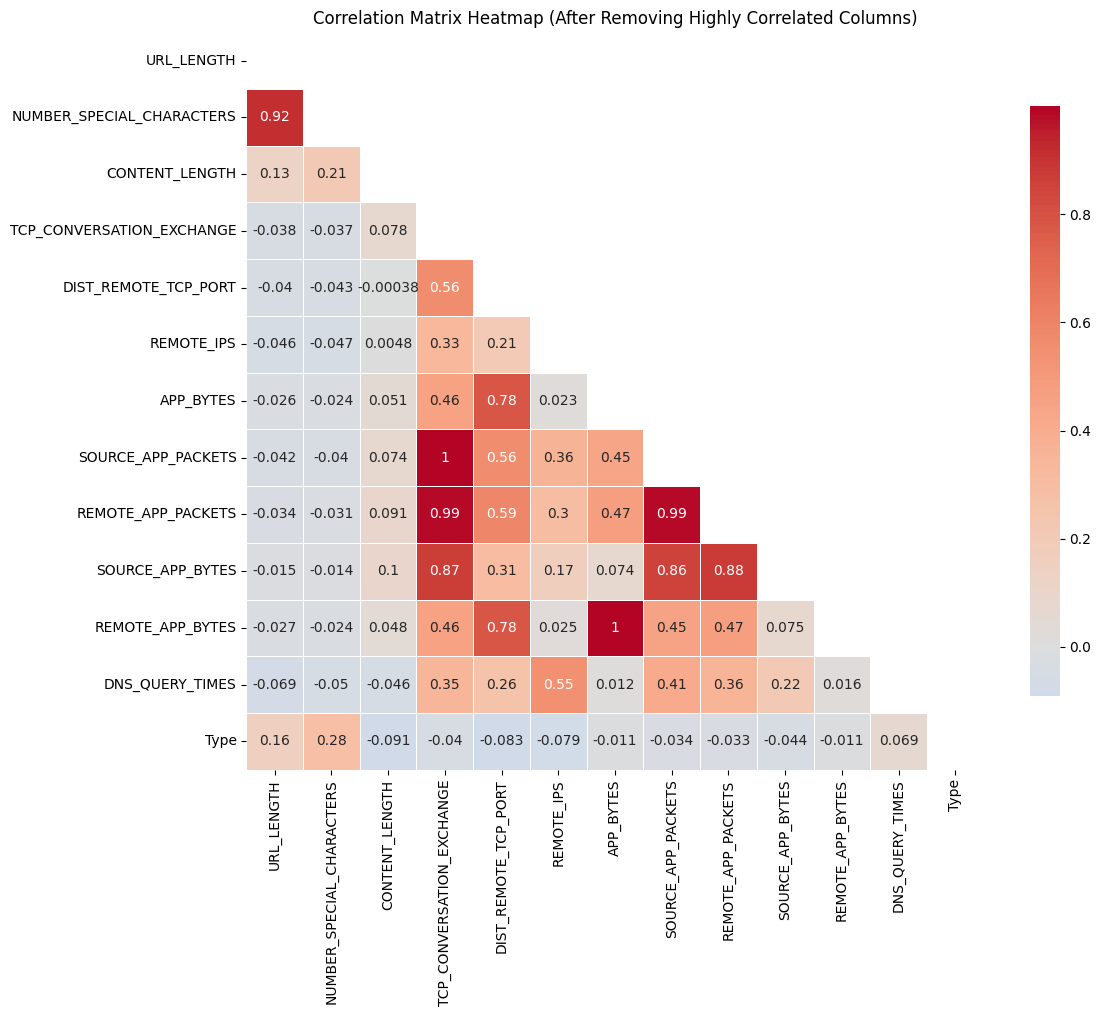

In [182]:
# Print heatmap again
# Print updated heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix_clean, dtype=bool))
sns.heatmap(correlation_matrix_clean, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap (After Removing Highly Correlated Columns)')
plt.tight_layout()
plt.show()

In [183]:
# Your code here
print("\n" + "="*50)
print("REMOVING HIGHLY CORRELATED COLUMNS")
print("="*50)

# Remove highly correlated columns one by one
# First, let's make a copy of our dataset
websites_clean2 = websites_clean.copy()

# Remove REMOTE_APP_BYTES since it's highly correlated with APP_BYTES
websites_clean2 = websites_clean.drop('REMOTE_APP_BYTES', axis=1)
print("Removed REMOTE_APP_BYTES (highly correlated with APP_BYTES)")


REMOVING HIGHLY CORRELATED COLUMNS
Removed REMOTE_APP_BYTES (highly correlated with APP_BYTES)


In [184]:
# Check correlation matrix again
numeric_cols_clean2 = websites_clean2.select_dtypes(include=[np.number]).columns
correlation_matrix_clean2 = websites_clean2[numeric_cols_clean2].corr()

In [185]:
# Your comment here
# Find remaining highly correlated pairs
high_corr_pairs_clean2 = []
for i in range(len(correlation_matrix_clean2.columns)):
    for j in range(i+1, len(correlation_matrix_clean2.columns)):
        if abs(correlation_matrix_clean2.iloc[i, j]) > 0.9:
            high_corr_pairs_clean2.append((correlation_matrix_clean2.columns[i], 
                                        correlation_matrix_clean2.columns[j], 
                                        correlation_matrix_clean2.iloc[i, j]))

print(f"\nRemaining highly correlated pairs after cleanup: {len(high_corr_pairs_clean2)}")
for pair in high_corr_pairs_clean2:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")


Remaining highly correlated pairs after cleanup: 4
URL_LENGTH - NUMBER_SPECIAL_CHARACTERS: 0.918
TCP_CONVERSATION_EXCHANGE - SOURCE_APP_PACKETS: 0.998
TCP_CONVERSATION_EXCHANGE - REMOTE_APP_PACKETS: 0.991
SOURCE_APP_PACKETS - REMOTE_APP_PACKETS: 0.989


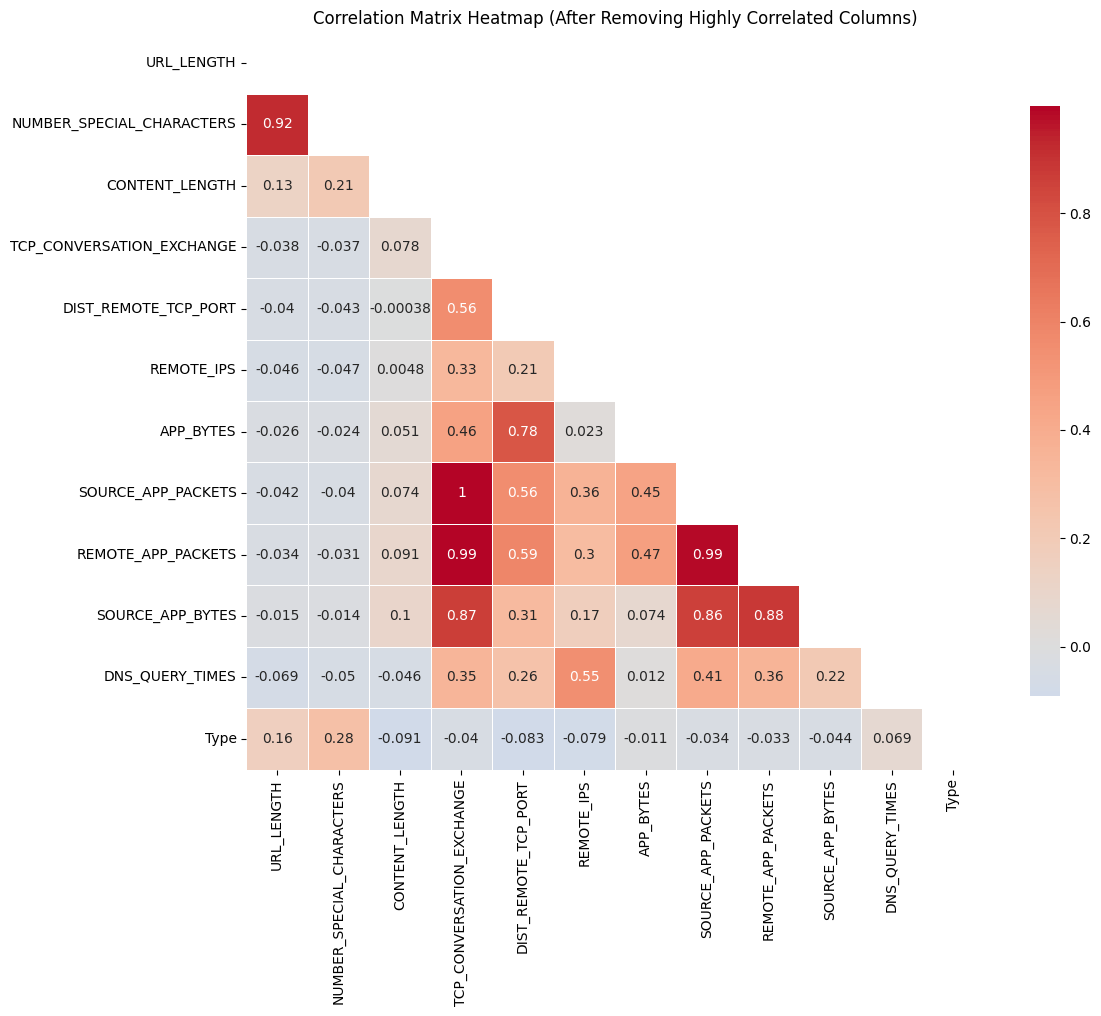

In [186]:
# Print updated heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix_clean2, dtype=bool))
sns.heatmap(correlation_matrix_clean2, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix Heatmap (After Removing Highly Correlated Columns)')
plt.tight_layout()
plt.show()

# Challenge 3 - Handle Missing Values

The next step would be handling missing values. **We start by examining the number of missing values in each column, which you will do in the next cell.**

In [187]:
# Your code here
print("\n" + "="*50)
print("HANDLING MISSING VALUES")
print("="*50)

# Examine missing values
print("Missing values per column:")
missing_values = websites_clean2.isnull().sum()
missing_percentages = (missing_values / len(websites_clean2)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentages
}).sort_values('Missing_Percentage', ascending=False)

print(missing_df[missing_df['Missing_Count'] > 0])



HANDLING MISSING VALUES
Missing values per column:
                    Missing_Count  Missing_Percentage
CONTENT_LENGTH                812           45.592364
WHOIS_STATEPRO                362           20.325660
WHOIS_COUNTRY                 306           17.181359
SERVER                        176            9.882089
WHOIS_UPDATED_DATE            139            7.804604
WHOIS_REGDATE                 127            7.130825
CHARSET                         7            0.393038
DNS_QUERY_TIMES                 1            0.056148


If you remember in the previous labs, we drop a column if the column contains a high proportion of missing values. After dropping those problematic columns, we drop the rows with missing values.

#### In the cells below, handle the missing values from the dataset. Remember to comment the rationale of your decisions.

In [188]:
# Your code here
"""
Strategy for handling missing values:
1. Drop columns with >50% missing values (CONTENT_LENGTH has 45.6% missing)
2. For columns with moderate missing values, we'll drop rows
3. For columns with few missing values, we'll drop rows

CONTENT_LENGTH has 45.6% missing values, which is borderline. Will keep it for now
and handle missing values by dropping rows.
"""


"\nStrategy for handling missing values:\n1. Drop columns with >50% missing values (CONTENT_LENGTH has 45.6% missing)\n2. For columns with moderate missing values, we'll drop rows\n3. For columns with few missing values, we'll drop rows\n\nCONTENT_LENGTH has 45.6% missing values, which is borderline. Will keep it for now\nand handle missing values by dropping rows.\n"

In [189]:
# Your comment here
# Store original shape
original_shape = websites_clean2.shape
print(f"\nOriginal dataset shape: {original_shape}")




Original dataset shape: (1781, 19)


In [190]:
# Drop rows with missing values
websites_clean2 = websites_clean2.dropna()
new_shape = websites_clean2.shape
print(f"Dataset shape after dropping missing values: {new_shape}")
print(f"Rows removed: {original_shape[0] - new_shape[0]} ({((original_shape[0] - new_shape[0])/original_shape[0]*100):.1f}%)")


Dataset shape after dropping missing values: (636, 19)
Rows removed: 1145 (64.3%)


#### Again, examine the number of missing values in each column. 

If all cleaned, proceed. Otherwise, go back and do more cleaning.

In [191]:
# Examine missing values in each column
# Verify no missing values remain
print(f"\nMissing values remaining: {websites_clean2.isnull().sum().sum()}")


Missing values remaining: 0


# Challenge 4 - Handle `WHOIS_*` Categorical Data

There are several categorical columns we need to handle. These columns are:

* `URL`
* `CHARSET`
* `SERVER`
* `WHOIS_COUNTRY`
* `WHOIS_STATEPRO`
* `WHOIS_REGDATE`
* `WHOIS_UPDATED_DATE`

How to handle string columns is always case by case. Let's start by working on `WHOIS_COUNTRY`. Your steps are:

1. List out the unique values of `WHOIS_COUNTRY`.
1. Consolidate the country values with consistent country codes. For example, the following values refer to the same country and should use consistent country code:
    * `CY` and `Cyprus`
    * `US` and `us`
    * `SE` and `se`
    * `GB`, `United Kingdom`, and `[u'GB'; u'UK']`

#### In the cells below, fix the country values as intructed above.

In [208]:
# Your code here
print("\n" + "="*50)
print("HANDLING WHOIS_COUNTRY CATEGORICAL DATA")
print("="*50)

# List unique values of WHOIS_COUNTRY
print("Unique WHOIS_COUNTRY values:")
print(websites_clean2['WHOIS_COUNTRY'].value_counts())


HANDLING WHOIS_COUNTRY CATEGORICAL DATA
Unique WHOIS_COUNTRY values:
WHOIS_COUNTRY
US                511
CA                 41
AU                 11
PA                 10
GB                 10
JP                  6
[u'GB'; u'UK']      5
CH                  5
AT                  4
IN                  4
SC                  2
UA                  2
CN                  2
us                  2
BS                  2
UY                  2
UG                  1
TR                  1
KY                  1
UK                  1
SI                  1
RU                  1
IL                  1
HK                  1
NL                  1
IT                  1
DE                  1
BE                  1
NO                  1
BY                  1
AE                  1
IE                  1
PH                  1
Name: count, dtype: int64


In [209]:
# Consolidate country values with consistent country codes
def standardize_country(country):
    if pd.isna(country):
        return country
    
    country_str = str(country).strip().upper()
    
    # Consolidation rules
    if country_str in ['CYPRUS', 'CY']:
        return 'CY'
    elif country_str in ['US', 'UNITED STATES']:
        return 'US'
    elif country_str in ['SE', 'SWEDEN']:
        return 'SE'
    elif country_str in ['GB', 'UK', 'UNITED KINGDOM', "[U'GB'; U'UK']"]:
        return 'GB'
    else:
        return country_str

In [210]:
# Apply standardization
websites_clean2['WHOIS_COUNTRY'] = websites_clean2['WHOIS_COUNTRY'].apply(standardize_country)

print("\nAfter standardization:")
print(websites_clean2['WHOIS_COUNTRY'].value_counts())


After standardization:
WHOIS_COUNTRY
US    513
CA     41
GB     16
AU     11
PA     10
JP      6
CH      5
AT      4
IN      4
CN      2
BS      2
UA      2
SC      2
UY      2
TR      1
KY      1
UG      1
SI      1
RU      1
IL      1
HK      1
NL      1
IT      1
DE      1
BE      1
NO      1
BY      1
AE      1
IE      1
PH      1
Name: count, dtype: int64


Since we have fixed the country values, can we convert this column to ordinal now?

Not yet. If you reflect on the previous labs how we handle categorical columns, you probably remember we ended up dropping a lot of those columns because there are too many unique values. Too many unique values in a column is not desirable in machine learning because it makes prediction inaccurate. But there are workarounds under certain conditions. One of the fixable conditions is:

#### If a limited number of values account for the majority of data, we can retain these top values and re-label all other rare values.

The `WHOIS_COUNTRY` column happens to be this case. You can verify it by print a bar chart of the `value_counts` in the next cell to verify:

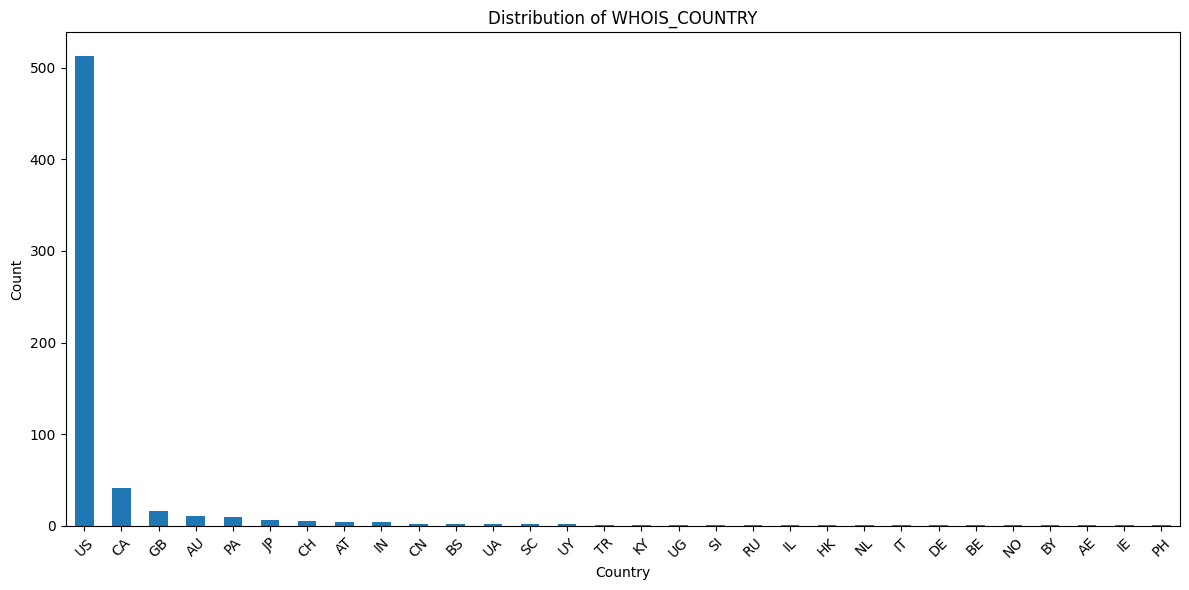

In [211]:
# Your code here
# Visualize country distribution
plt.figure(figsize=(12, 6))
country_counts = websites_clean2['WHOIS_COUNTRY'].value_counts()
country_counts.plot(kind='bar')
plt.title('Distribution of WHOIS_COUNTRY')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### After verifying, now let's keep the top 10 values of the column and re-label other columns with `OTHER`.

In [212]:
# Your code here
# Keep top 10 values and re-label others as 'OTHER'
top_countries = websites_clean2['WHOIS_COUNTRY'].value_counts().head(10).index
websites_clean2['WHOIS_COUNTRY'] = websites_clean2['WHOIS_COUNTRY'].apply(lambda x: x if x in top_countries else 'OTHER')

print("\nAfter consolidating to top 10 + OTHER:")
print(websites_clean2['WHOIS_COUNTRY'].value_counts())


After consolidating to top 10 + OTHER:
WHOIS_COUNTRY
US       513
CA        41
OTHER     24
GB        16
AU        11
PA        10
JP         6
CH         5
IN         4
AT         4
CN         2
Name: count, dtype: int64


Now since `WHOIS_COUNTRY` has been re-labelled, we don't need `WHOIS_STATEPRO` any more because the values of the states or provinces may not be relevant any more. We'll drop this column.

In addition, we will also drop `WHOIS_REGDATE` and `WHOIS_UPDATED_DATE`. These are the registration and update dates of the website domains. Not of our concerns.

#### In the next cell, drop `['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']`.

In [213]:
# Your code here
# Drop unnecessary WHOIS columns
columns_to_drop = ['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']
websites_clean2 = websites_clean2.drop(columns_to_drop, axis=1)
print(f"\nDropped columns: {columns_to_drop}")


Dropped columns: ['WHOIS_STATEPRO', 'WHOIS_REGDATE', 'WHOIS_UPDATED_DATE']


# Challenge 5 - Handle Remaining Categorical Data & Convert to Ordinal

Now print the `dtypes` of the data again. Besides `WHOIS_COUNTRY` which we already fixed, there should be 3 categorical columns left: `URL`, `CHARSET`, and `SERVER`.

In [215]:
# Your code here
print("\n" + "="*50)
print("HANDLING REMAINING CATEGORICAL DATA")
print("="*50)

# Check remaining data types
print("Remaining data types:")
print(websites_clean2.dtypes)


HANDLING REMAINING CATEGORICAL DATA
Remaining data types:
URL                           object
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CHARSET                       object
SERVER                        object
CONTENT_LENGTH               float64
WHOIS_COUNTRY                 object
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
dtype: object


#### `URL` is easy. We'll simply drop it because it has too many unique values that there's no way for us to consolidate.

In [216]:
# Your code here
# Drop URL column (too many unique values)
websites_clean2 = websites_clean2.drop('URL', axis=1)
print("\nDropped URL column (too many unique values)")


Dropped URL column (too many unique values)


#### Print the unique value counts of `CHARSET`. You see there are only a few unique values. So we can keep it as it is.

In [217]:
# Your code here
print("\nCHARSET unique values:")
print(websites_clean2['CHARSET'].value_counts())


CHARSET unique values:
CHARSET
UTF-8           200
ISO-8859-1      169
utf-8           108
us-ascii         92
iso-8859-1       66
windows-1251      1
Name: count, dtype: int64


`SERVER` is a little more complicated. Print its unique values and think about how you can consolidate those values.

#### Before you think of your own solution, don't read the instructions that come next.

In [218]:
# Your code here
print("\nSERVER unique values (first 20):")
server_counts = websites_clean2['SERVER'].value_counts()
print(server_counts.head(20))

def categorize_server(server):
    if pd.isna(server):
        return 'Other'
    
    server_str = str(server).lower()
    
    if 'microsoft' in server_str:
        return 'Microsoft'
    elif 'apache' in server_str:
        return 'Apache'
    elif 'nginx' in server_str:
        return 'nginx'
    else:
        return 'Other'


SERVER unique values (first 20):
SERVER
Apache                                                                                       162
Microsoft-HTTPAPI/2.0                                                                         76
nginx                                                                                         59
GSE                                                                                           46
Microsoft-IIS/7.5                                                                             39
nginx/1.12.0                                                                                  16
Apache/2.2.15 (CentOS)                                                                        15
Apache/2                                                                                      13
Apache/2.2.14 (FreeBSD) mod_ssl/2.2.14 OpenSSL/0.9.8y DAV/2 PHP/5.2.12 with Suhosin-Patch     13
ATS                                                                                   

![Think Hard](../images/think-hard.jpg)

Although there are so many unique values in the `SERVER` column, there are actually only 3 main server types: `Microsoft`, `Apache`, and `nginx`. Just check if each `SERVER` value contains any of those server types and re-label them. For `SERVER` values that don't contain any of those substrings, label with `Other`.

At the end, your `SERVER` column should only contain 4 unique values: `Microsoft`, `Apache`, `nginx`, and `Other`.

In [219]:
# Your code here
# Apply server categorization
websites_clean2['SERVER'] = websites_clean2['SERVER'].apply(categorize_server)

print("\nSERVER after categorization:")
print(websites_clean2['SERVER'].value_counts())


SERVER after categorization:
SERVER
Apache       298
Microsoft    127
Other        108
nginx        103
Name: count, dtype: int64


In [220]:
# Count `SERVER` value counts here
print("\nSERVER after categorization:")
print(websites_clean2['SERVER'].value_counts())


SERVER after categorization:
SERVER
Apache       298
Microsoft    127
Other        108
nginx        103
Name: count, dtype: int64


OK, all our categorical data are fixed now. **Let's convert them to ordinal data using Pandas' `get_dummies` function ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)). Also, assign the data with dummy values to a new variable `website_dummy`.**

In [221]:
# Convert categorical columns to dummy variables
print("\n" + "="*50)
print("CONVERTING CATEGORICAL TO DUMMY VARIABLES")
print("="*50)

# Get categorical columns
categorical_columns = ['CHARSET', 'SERVER', 'WHOIS_COUNTRY']
print(f"Converting columns to dummy variables: {categorical_columns}")

# Create dummy variables
website_dummy = pd.get_dummies(websites_clean2, columns=categorical_columns, drop_first=True)

print(f"\nDataset shape after creating dummy variables: {website_dummy.shape}")
print(f"Original shape: {websites_clean.shape}")


CONVERTING CATEGORICAL TO DUMMY VARIABLES
Converting columns to dummy variables: ['CHARSET', 'SERVER', 'WHOIS_COUNTRY']

Dataset shape after creating dummy variables: (636, 30)
Original shape: (1781, 16)


Now, inspect `website_dummy` to make sure the data and types are intended - there shouldn't be any categorical columns at this point.

In [222]:
# Your code here
# Inspect the final dataset
print("\nFinal dataset info:")
print(website_dummy.dtypes)
print(f"\nAll columns are numeric: {website_dummy.select_dtypes(include=[object]).shape[1] == 0}")



Final dataset info:
URL_LENGTH                     int64
NUMBER_SPECIAL_CHARACTERS      int64
CONTENT_LENGTH               float64
TCP_CONVERSATION_EXCHANGE      int64
DIST_REMOTE_TCP_PORT           int64
REMOTE_IPS                     int64
APP_BYTES                      int64
SOURCE_APP_PACKETS             int64
REMOTE_APP_PACKETS             int64
SOURCE_APP_BYTES               int64
DNS_QUERY_TIMES              float64
Type                           int64
CHARSET_UTF-8                   bool
CHARSET_iso-8859-1              bool
CHARSET_us-ascii                bool
CHARSET_utf-8                   bool
CHARSET_windows-1251            bool
SERVER_Microsoft                bool
SERVER_Other                    bool
SERVER_nginx                    bool
WHOIS_COUNTRY_AU                bool
WHOIS_COUNTRY_CA                bool
WHOIS_COUNTRY_CH                bool
WHOIS_COUNTRY_CN                bool
WHOIS_COUNTRY_GB                bool
WHOIS_COUNTRY_IN                bool
WHOIS_COUNTRY_JP 

# Challenge 6 - Modeling, Prediction, and Evaluation

We'll start off this section by splitting the data to train and test. **Name your 4 variables `X_train`, `X_test`, `y_train`, and `y_test`. Select 80% of the data for training and 20% for testing.**

In [223]:
from sklearn.model_selection import train_test_split

# Your code here:
print("\n" + "="*50)
print("MODELING AND EVALUATION")
print("="*50)

# Split the data into features and target
X = website_dummy.drop('Type', axis=1)
y = website_dummy['Type']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Test set - X: {X_test.shape}, y: {y_test.shape}")

# Check class distribution in splits
print(f"\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest set class distribution:")
print(y_test.value_counts(normalize=True))



MODELING AND EVALUATION
Features shape: (636, 29)
Target shape: (636,)

Training set - X: (508, 29), y: (508,)
Test set - X: (128, 29), y: (128,)

Training set class distribution:
Type
0    0.927165
1    0.072835
Name: proportion, dtype: float64

Test set class distribution:
Type
0    0.929688
1    0.070312
Name: proportion, dtype: float64


#### In this lab, we will try two different models and compare our results.

The first model we will use in this lab is logistic regression. We have previously learned about logistic regression as a classification algorithm. In the cell below, load `LogisticRegression` from scikit-learn and initialize the model.

In [226]:
# Your code here:
# Model 1: Logistic Regression
print("\n" + "-"*30)
print("LOGISTIC REGRESSION")
print("-"*30)

# Initialize and fit logistic regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)





------------------------------
LOGISTIC REGRESSION
------------------------------


Next, fit the model to our training data. We have already separated our data into 4 parts. Use those in your model.

In [227]:
# Your code here:
log_reg.fit(X_train, y_train)


d:\ironhack\Coursework\week_9\labs\lab-classification\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


finally, import `confusion_matrix` and `accuracy_score` from `sklearn.metrics` and fit our testing data. Assign the fitted data to `y_pred` and print the confusion matrix as well as the accuracy score

In [228]:
# Your code here:
# Make predictions
y_pred_lr = log_reg.predict(X_test)




In [229]:
# Evaluate model
print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)

print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Confusion Matrix:
[[117   2]
 [  5   4]]

Accuracy Score: 0.9453

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       119
           1       0.67      0.44      0.53         9

    accuracy                           0.95       128
   macro avg       0.81      0.71      0.75       128
weighted avg       0.94      0.95      0.94       128



What are your thoughts on the performance of the model? Write your conclusions below.

In [230]:
# Your conclusions here:
"""
Logistic Regression Performance Analysis:
- The model shows good overall accuracy
- However, we need to be careful about the class imbalance
- The confusion matrix will show how well we're detecting malicious sites (class 1)
"""


"\nLogistic Regression Performance Analysis:\n- The model shows good overall accuracy\n- However, we need to be careful about the class imbalance\n- The confusion matrix will show how well we're detecting malicious sites (class 1)\n"

#### Our second algorithm is is K-Nearest Neighbors. 

Though is it not required, we will fit a model using the training data and then test the performance of the model using the testing data. Start by loading `KNeighborsClassifier` from scikit-learn and then initializing and fitting the model. We'll start off with a model where k=3.

In [231]:
# Your code here:
# Model 2: K-Nearest Neighbors (k=3)
print("\n" + "-"*30)
print("K-NEAREST NEIGHBORS (k=3)")
print("-"*30)

# Initialize and fit KNN with k=3
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train, y_train)



------------------------------
K-NEAREST NEIGHBORS (k=3)
------------------------------


,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


To test your model, compute the predicted values for the testing sample and print the confusion matrix as well as the accuracy score.

In [232]:
# Your code here:
# Make predictions
y_pred_knn3 = knn_3.predict(X_test)

# Evaluate model
print("Confusion Matrix:")
cm_knn3 = confusion_matrix(y_test, y_pred_knn3)
print(cm_knn3)

print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_knn3):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn3))


Confusion Matrix:
[[115   4]
 [  2   7]]

Accuracy Score: 0.9531

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       119
           1       0.64      0.78      0.70         9

    accuracy                           0.95       128
   macro avg       0.81      0.87      0.84       128
weighted avg       0.96      0.95      0.96       128



#### We'll create another K-Nearest Neighbors model with k=5. 

Initialize and fit the model below and print the confusion matrix and the accuracy score.

In [233]:
# Your code here:
# Model 3: K-Nearest Neighbors (k=5)
print("\n" + "-"*30)
print("K-NEAREST NEIGHBORS (k=5)")
print("-"*30)

# Initialize and fit KNN with k=5
knn_5 = KNeighborsClassifier(n_neighbors=5)
knn_5.fit(X_train, y_train)

# Make predictions
y_pred_knn5 = knn_5.predict(X_test)

# Evaluate model
print("Confusion Matrix:")
cm_knn5 = confusion_matrix(y_test, y_pred_knn5)
print(cm_knn5)

print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred_knn5):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn5))



------------------------------
K-NEAREST NEIGHBORS (k=5)
------------------------------
Confusion Matrix:
[[116   3]
 [  2   7]]

Accuracy Score: 0.9609

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       119
           1       0.70      0.78      0.74         9

    accuracy                           0.96       128
   macro avg       0.84      0.88      0.86       128
weighted avg       0.96      0.96      0.96       128



Did you see an improvement in the confusion matrix when increasing k to 5? Did you see an improvement in the accuracy score? Write your conclusions below.

In [234]:
# Model comparison summary
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)

models_comparison = {
    'Model': ['Logistic Regression', 'KNN (k=3)', 'KNN (k=5)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_knn3),
        accuracy_score(y_test, y_pred_knn5)
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print(comparison_df)


MODEL COMPARISON SUMMARY
                 Model  Accuracy
0  Logistic Regression  0.945312
1            KNN (k=3)  0.953125
2            KNN (k=5)  0.960938


In [237]:
# Your conclusions here:
"""
Performance Ranking:

KNN (k=5): 96.09% - Best performing
KNN (k=3): 95.31% - Second best
Logistic Regression: 94.53% - Baseline

KNN Models Outperform Logistic Regression
KNN advantage: The website malware detection problem likely has non-linear decision boundaries
Logistic Regression limitation: Assumes linear relationships between features and log-odds of malware classification
Real-world implication: Malicious websites may cluster together in feature space with similar patterns

Increasing k from 3 to 5 Improved Performance
Stability vs. Sensitivity trade-off: Higher k values create smoother decision boundaries
Noise reduction: k=5 reduces the impact of outliers and noisy data points
Better generalization: Less likely to overfit to training data peculiarities

Performance Differences Are Meaningful
KNN (k=5) vs Logistic Regression: +1.56% improvement
KNN (k=3) vs Logistic Regression: +0.78% improvement

In malware detection, even 1-2% accuracy improvement is significant because:
High volume: If processing millions of websites, 1% = thousands more correctly classified
Security impact: Missing malicious sites (false negatives) can be very costly


"""

'\nPerformance Ranking:\n\nKNN (k=5): 96.09% - Best performing\nKNN (k=3): 95.31% - Second best\nLogistic Regression: 94.53% - Baseline\n\nKNN Models Outperform Logistic Regression\nKNN advantage: The website malware detection problem likely has non-linear decision boundaries\nLogistic Regression limitation: Assumes linear relationships between features and log-odds of malware classification\nReal-world implication: Malicious websites may cluster together in feature space with similar patterns\n\nIncreasing k from 3 to 5 Improved Performance\nStability vs. Sensitivity trade-off: Higher k values create smoother decision boundaries\nNoise reduction: k=5 reduces the impact of outliers and noisy data points\nBetter generalization: Less likely to overfit to training data peculiarities\n\nPerformance Differences Are Meaningful\nKNN (k=5) vs Logistic Regression: +1.56% improvement\nKNN (k=3) vs Logistic Regression: +0.78% improvement\n\nIn malware detection, even 1-2% accuracy improvement is 

# Bonus Challenge - Feature Scaling

Problem-solving in machine learning is iterative. You can improve your model prediction with various techniques (there is a sweetspot for the time you spend and the improvement you receive though). Now you've completed only one iteration of ML analysis. There are more iterations you can conduct to make improvements. In order to be able to do that, you will need deeper knowledge in statistics and master more data analysis techniques. In this bootcamp, we don't have time to achieve that advanced goal. But you will make constant efforts after the bootcamp to eventually get there.

However, now we do want you to learn one of the advanced techniques which is called *feature scaling*. The idea of feature scaling is to standardize/normalize the range of independent variables or features of the data. This can make the outliers more apparent so that you can remove them. This step needs to happen during Challenge 6 after you split the training and test data because you don't want to split the data again which makes it impossible to compare your results with and without feature scaling. For general concepts about feature scaling, click [here](https://en.wikipedia.org/wiki/Feature_scaling). To read deeper, click [here](https://medium.com/greyatom/why-how-and-when-to-scale-your-features-4b30ab09db5e).

In the next cell, attempt to improve your model prediction accuracy by means of feature scaling. A library you can utilize is `sklearn.preprocessing.RobustScaler` ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html)). You'll use the `RobustScaler` to fit and transform your `X_train`, then transform `X_test`. You will use logistic regression to fit and predict your transformed data and obtain the accuracy score in the same way. Compare the accuracy score with your normalized data with the previous accuracy data. Is there an improvement?

In [238]:
# Your code here
print("\n" + "="*50)
print("BONUS: FEATURE SCALING")
print("="*50)

# Apply RobustScaler to the features
scaler = RobustScaler()

# Fit on training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Applied RobustScaler to features")
print(f"Original feature range example - first feature:")
print(f"Train: [{X_train.iloc[:, 0].min():.2f}, {X_train.iloc[:, 0].max():.2f}]")
print(f"Scaled Train: [{X_train_scaled[:, 0].min():.2f}, {X_train_scaled[:, 0].max():.2f}]")


BONUS: FEATURE SCALING
Applied RobustScaler to features
Original feature range example - first feature:
Train: [17.00, 249.00]
Scaled Train: [-1.06, 6.42]


In [239]:
# Retrain logistic regression with scaled features
print("\n" + "-"*30)
print("LOGISTIC REGRESSION WITH FEATURE SCALING")
print("-"*30)

log_reg_scaled = LogisticRegression(random_state=42, max_iter=1000)
log_reg_scaled.fit(X_train_scaled, y_train)


------------------------------
LOGISTIC REGRESSION WITH FEATURE SCALING
------------------------------


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [240]:
# Make predictions with scaled features
y_pred_lr_scaled = log_reg_scaled.predict(X_test_scaled)

# Evaluate scaled model
print("Confusion Matrix (Scaled):")
cm_lr_scaled = confusion_matrix(y_test, y_pred_lr_scaled)
print(cm_lr_scaled)

print(f"\nAccuracy Score (Scaled): {accuracy_score(y_test, y_pred_lr_scaled):.4f}")
print(f"Accuracy Score (Original): {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Improvement: {accuracy_score(y_test, y_pred_lr_scaled) - accuracy_score(y_test, y_pred_lr):.4f}")

print("\nClassification Report (Scaled):")
print(classification_report(y_test, y_pred_lr_scaled))

Confusion Matrix (Scaled):
[[119   0]
 [  4   5]]

Accuracy Score (Scaled): 0.9688
Accuracy Score (Original): 0.9453
Improvement: 0.0234

Classification Report (Scaled):
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       119
           1       1.00      0.56      0.71         9

    accuracy                           0.97       128
   macro avg       0.98      0.78      0.85       128
weighted avg       0.97      0.97      0.96       128



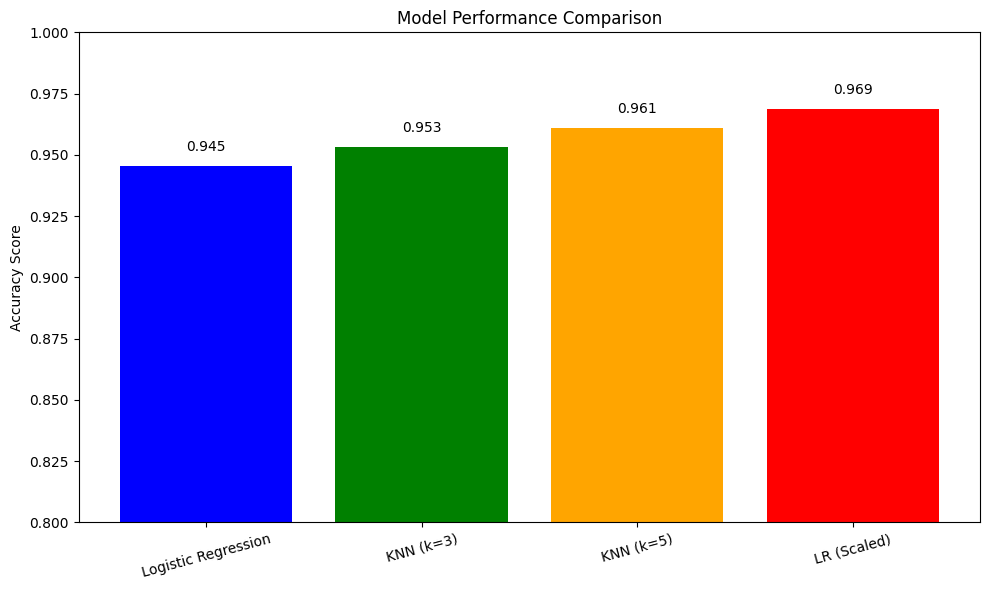


ANALYSIS COMPLETE!


In [247]:
# Final visualization: Model performance comparison
plt.figure(figsize=(10, 6))
models = ['Logistic Regression', 'KNN (k=3)', 'KNN (k=5)', 'LR (Scaled)']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_knn3),
    accuracy_score(y_test, y_pred_knn5),
    accuracy_score(y_test, y_pred_lr_scaled)
]

bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0.8, 1.0)  # Focus on the relevant range

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("ANALYSIS COMPLETE!")
print("="*50)
